In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
def load_iris(ratio=0.8):
    features, target = datasets.load_iris(True)
    
    # 只保留0,1分类 -- 把任务变成二分类任务
    idx = np.bitwise_or(target == 0, target == 1)
    features = features[idx]
    target = target[idx]
    
    num_samples = len(target)
    num_train = math.ceil(num_samples * ratio)
    
    
    # 随机打乱数据
    idx = np.random.permutation(np.arange(num_samples))
    traindata = features[idx[:num_train]], target[idx[:num_train]]
    validdata = features[idx[num_train:]], target[idx[num_train:]]
    
    return traindata, validdata

# 作业三

## 四、Logistic回归与最大熵模型

要求：

* 通过logistic回归来对只含两类的iris数据集进行二分类
* 利用梯度下降法（定步长）
* 在尽量不修改代码结构的前提下完成工作

ETA：1-5 hours

读取数据

In [3]:
(X_train, Y_train), (X_valid, Y_valid) = load_iris()

### 一、定义线性回归函数

为了简化推导，记$\hat{Y} = WX+b$

预测 -- 取下述概率最大的值：

$$P(class=1|x) = \frac{\exp(\hat{Y})}{1+\exp(\hat{Y})}$$
$$P(class=0|x) = \frac{1}{1+\exp(\hat{Y})}$$

In [4]:
class Logistic:
    def __init__(self, in_channels):
        self.W = np.zeros(in_channels)
        self.b = 0
        
        
    def __call__(self, X):
        """计算 \hat{Y} = WX + b，其中WX为内积"""
        assert len(X.shape) == 2
        # 这里只计算WX+b，因为在计算对数似然函数时需要用到该值
        return X @ self.W + self.b
    
    
    def predict(self, X):
        """预测X所属的类别"""
        assert len(X.shape) == 2
        expY = np.exp(self(X))
        prob = np.vstack([np.ones_like(expY), expY])/(1+expY)
        return np.argmax(prob, axis=0)
    
    
def accuracy(real, predict):
    """计算预测准确度"""
    return np.sum(real == predict)/real.size

In [5]:
# 测试LinearLayer是否能够正确调用
num_features = X_train.shape[-1]
f = Logistic(num_features)

f(X_train)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [6]:
f.predict(X_train)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [7]:
accuracy(Y_train, f.predict(X_train)) # 瞎猜 -- 50%左右的分类准确度

0.5

### 二、定义误差 -- 对数似然函数

$$ L(Y, \hat{Y}) = \sum_{i=1}^{N} [y_i\hat{y}_i - log(1+\exp(\hat{y}_i))]$$

其中$Y$为真实值，$\hat{Y} = Wx + b$为预测值

注：$L(Y, \hat{Y}) \neq L(\hat{Y}, Y)$

In [8]:
class NegativeLogLikelihood:
    # 针对二项Logistic的负对数似然函数
    # 梯度下降法求解的问题实际上是 min. -L
    def __call__(self, real, predict):
        assert len(real.shape) == 1
        assert real.size == predict.size
        
        return -np.sum(real*predict - np.log(1+np.exp(predict)))

In [9]:
# 测试loss是否能够正确调用
loss = NegativeLogLikelihood()
loss(Y_train, f(X_train))

55.451774444795625

### 三、计算梯度

为了使用梯度下降法，需要计算梯度$(\frac{\partial L}{\partial W}, \frac{\partial L}{\partial b})$

利用链式法则：

$$ \frac{\partial L}{\partial W} = \sum_{i=1}^{N}\frac{\partial L}{\partial \hat{Y}_i} \frac{\partial \hat{Y}_i}{\partial W} $$
$$ \frac{\partial L}{\partial b} = \sum_{i=1}^{N}\frac{\partial L}{\partial \hat{Y}_i} \frac{\partial \hat{Y}_i}{\partial b} $$

In [10]:
def grad(Y, X, Y_out):
    """
    计算负对数似然函数在(X, Y)上关于W与b的偏导数
    Inputs:
      Y: shape (N, )
        类别的真实值
      X: shape (N, C)
        输入特征
      Y_out: shape (N, )
        Y_out = WX+b

    Outputs:
      dLdW: shape (C, )
      dLdb: shape (1, )
    """
    expY_out = np.exp(Y_out)
    # 实现它
    dLdY = -Y + expY_out/(1+expY_out) # dLdY.shape == (?, ) （?为占位符, 不需要回答..)
    dYdW = X # dYdW.shape == (?, 4)
    dYdb = 1 # dYdb.shape == (?, 1)
    
    dLdW = np.sum(dLdY.reshape(-1, 1)*dYdW, axis=0) # dLdW.shape == (4, )
    dLdb = np.array(np.sum(dLdY*dYdb, axis=0)) # dLdb.shape == (1, )
                 
    return dLdW, dLdb

In [11]:
# 测试梯度是否正确计算
grad(Y_train, X_train, f(X_train))

(array([-19.05,  11.95, -56.7 , -21.75]), array(0.))

In [12]:
class GradientDescent:
    def __init__(self, step=1e-3, thres=1e3):
        self.step = step
        self.thres = np.abs(thres)
        
        
    def update(self, f:Logistic, dLdW, dLdb):
        """利用梯度dW来更新f的权重"""
        f.W -= self.step * dLdW
        f.b -= self.step * dLdb

In [13]:
# 测试梯度更新是否正常工作
opt = GradientDescent(1e-3)
f = Logistic(num_features)

print(f"before update: loss:{loss(Y_train, f(X_train)):.4f} accuracy:{accuracy(Y_train, f.predict(X_train))}")

dLdW, dLdb = grad(Y_train, X_train, f(X_train))
opt.update(f, dLdW, dLdb)

print(f"after update: loss:{loss(Y_train, f(X_train)):.4f} accuracy:{accuracy(Y_train, f.predict(X_train))}")

before update: loss:55.4518 accuracy:0.5
after update: loss:51.9827 accuracy:0.5


### 四、把所有函数组合成一个完整的训练过程

In [14]:
num_features = X_train.shape[-1]
f = Logistic(num_features)
opt = GradientDescent(1e-5)
loss = NegativeLogLikelihood()

valid_losses = []
valid_accuracies = []
train_losses = []
train_accuracies = []
for i in range(1000):
    X, Y = X_train, Y_train
    
    Y_out = f(X)       
    dLdW, dLdb = grad(Y, X, Y_out)
    opt.update(f, dLdW, dLdb)
    
    cur_valid_loss = loss(Y_valid, f(X_valid))
    cur_valid_accu = accuracy(Y_valid, f.predict(X_valid))
    cur_train_loss = loss(Y, Y_out)
    cur_train_accu = accuracy(Y, f.predict(X))
    valid_losses.append(cur_valid_loss) 
    valid_accuracies.append(cur_valid_accu)
    train_losses.append(cur_train_loss)
    train_accuracies.append(cur_train_accu)
    
    if i%50 == 0:
        print(f"Iter {i}: loss {cur_train_loss:.4f}, accu: {cur_train_accu:.4f}, valid loss {cur_valid_loss:.4f}, valid accu {cur_valid_accu:.4f}")

Iter 0: loss 55.4518, accu: 0.5000, valid loss 13.8530, valid accu 0.5000
Iter 50: loss 53.6268, accu: 0.5000, valid loss 13.4166, valid accu 0.5000
Iter 100: loss 52.1204, accu: 0.5000, valid loss 13.0496, valid accu 0.5000
Iter 150: loss 50.7595, accu: 0.5000, valid loss 12.7138, valid accu 0.5000
Iter 200: loss 49.4809, accu: 0.5250, valid loss 12.3958, valid accu 0.5000
Iter 250: loss 48.2607, accu: 0.6750, valid loss 12.0911, valid accu 0.6000
Iter 300: loss 47.0893, accu: 0.8500, valid loss 11.7978, valid accu 0.9000
Iter 350: loss 45.9618, accu: 0.9500, valid loss 11.5151, valid accu 1.0000
Iter 400: loss 44.8758, accu: 1.0000, valid loss 11.2426, valid accu 1.0000
Iter 450: loss 43.8290, accu: 1.0000, valid loss 10.9798, valid accu 1.0000
Iter 500: loss 42.8199, accu: 1.0000, valid loss 10.7265, valid accu 1.0000
Iter 550: loss 41.8469, accu: 1.0000, valid loss 10.4822, valid accu 1.0000
Iter 600: loss 40.9084, accu: 1.0000, valid loss 10.2467, valid accu 1.0000
Iter 650: loss 

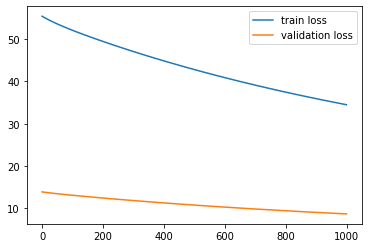

In [15]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.legend(["train loss", "validation loss"])

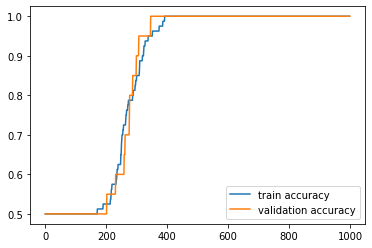

In [16]:
plt.plot(train_accuracies)
plt.plot(valid_accuracies)
plt.legend(["train accuracy", "validation accuracy"])

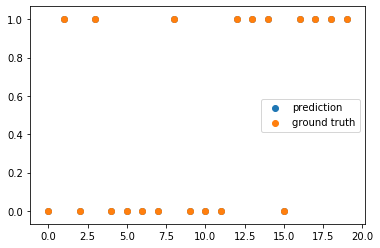

In [17]:
# 预测结果与真实结果重合
plt.scatter(np.arange(Y_valid.size), f.predict(X_valid))
plt.scatter(np.arange(Y_valid.size), Y_valid)
plt.legend(["prediction", "ground truth"])